In [1]:
import pandas as pd
import polars as pl
from plotnine import (ggplot, aes, geom_histogram, geom_point, geom_bar, theme, guides, facet_wrap, element_blank, geom_vline)

In [2]:
def time_convert(x): #useless
    x = str(x).replace('days ', '')
    (days, time) = x.split(' ')
    (h,m,s) = time.split(':')
    results = float(days) * 86400 + float(h) * 3600 + float(m) * 60 + float(s)
    return results

In [6]:
data1 = pl.scan_parquet('C:\\Users\\tuke-\\OneDrive - Cal Poly\\2_Winter_2024\\GSB521\\Assignment_2\\data\\combined.parquet', n_rows = 1000000)

In [8]:
# Polars
def parse_coordinate(coordinate):
    if len(coordinate) < 20:
        return coordinate
    else:
        coordinate = coordinate.replace(" ", "").replace(":", ",").split(",")
        x = coordinate[1]
        y = coordinate[3]
        return f"{x}" + "," + f"{y}"

data1 = data1.with_columns(
    pl.col('coordinate').map_elements(parse_coordinate, return_dtype=pl.Object)
)
data1 = data1.with_columns([
    pl.col('coordinate').map_elements(lambda x: int(x.split(",")[0]), return_dtype=pl.Int32).alias('x'),
    pl.col('coordinate').map_elements(lambda x: int(x.split(",")[1]), return_dtype=pl.Int32).alias('y')
])


In [5]:
# Polars

user_counts = data1.select("user").group_by("user").agg(pl.col('user').count().alias('count')).sort('count', descending = True)
user_counts = user_counts.with_columns(pl.col('count').cast(int))

user_counts = user_counts.filter(pl.col('count') > 20)

count_list = user_counts.select('user').collect(streaming = True)

data1 = data1.filter(pl.col('user').is_in(count_list))


In [11]:
user_counts.select(pl.len()).collect()

len
u32
41598


In [6]:
# Polars
sorted_ = data1.sort(pl.col(['user', 'timestamp']))

sorted_ = sorted_.with_columns(pl.col('timestamp').str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S%.f %Z").cast(pl.Datetime, strict = False))

sorted_ = sorted_.group_by('user').agg(pl.col('timestamp').diff(null_behavior = "drop").alias('diff'))

sorted_ = sorted_.explode('diff').drop_nulls()

sorted_std = sorted_.group_by('user').agg(pl.col('diff').std().alias('std'))

sorted_mean = sorted_.group_by('user').agg(pl.col('diff').mean().alias('mean'))

sorted_comb = sorted_std.join(sorted_mean, on = "user")

#print(sorted_std.collect(streaming=True))

#print(sorted_mean.collect(streaming=True))

#print(sorted_comb.collect(streaming=True))

In [12]:
sorted_comb.select(pl.len()).collect(streaming = True)

len
u32
28635


In [7]:
data_join1 = data1.join(sorted_comb, on = "user")

data_join2 = data_join1.join(user_counts, on = "user")

#data_join2.collect(streaming=True)

In [13]:
min_ = data_join2.select('timestamp').min().collect(streaming = True)

max_ = data_join2.select('timestamp').max().collect(streaming = True)

print(min_)
print(max_)

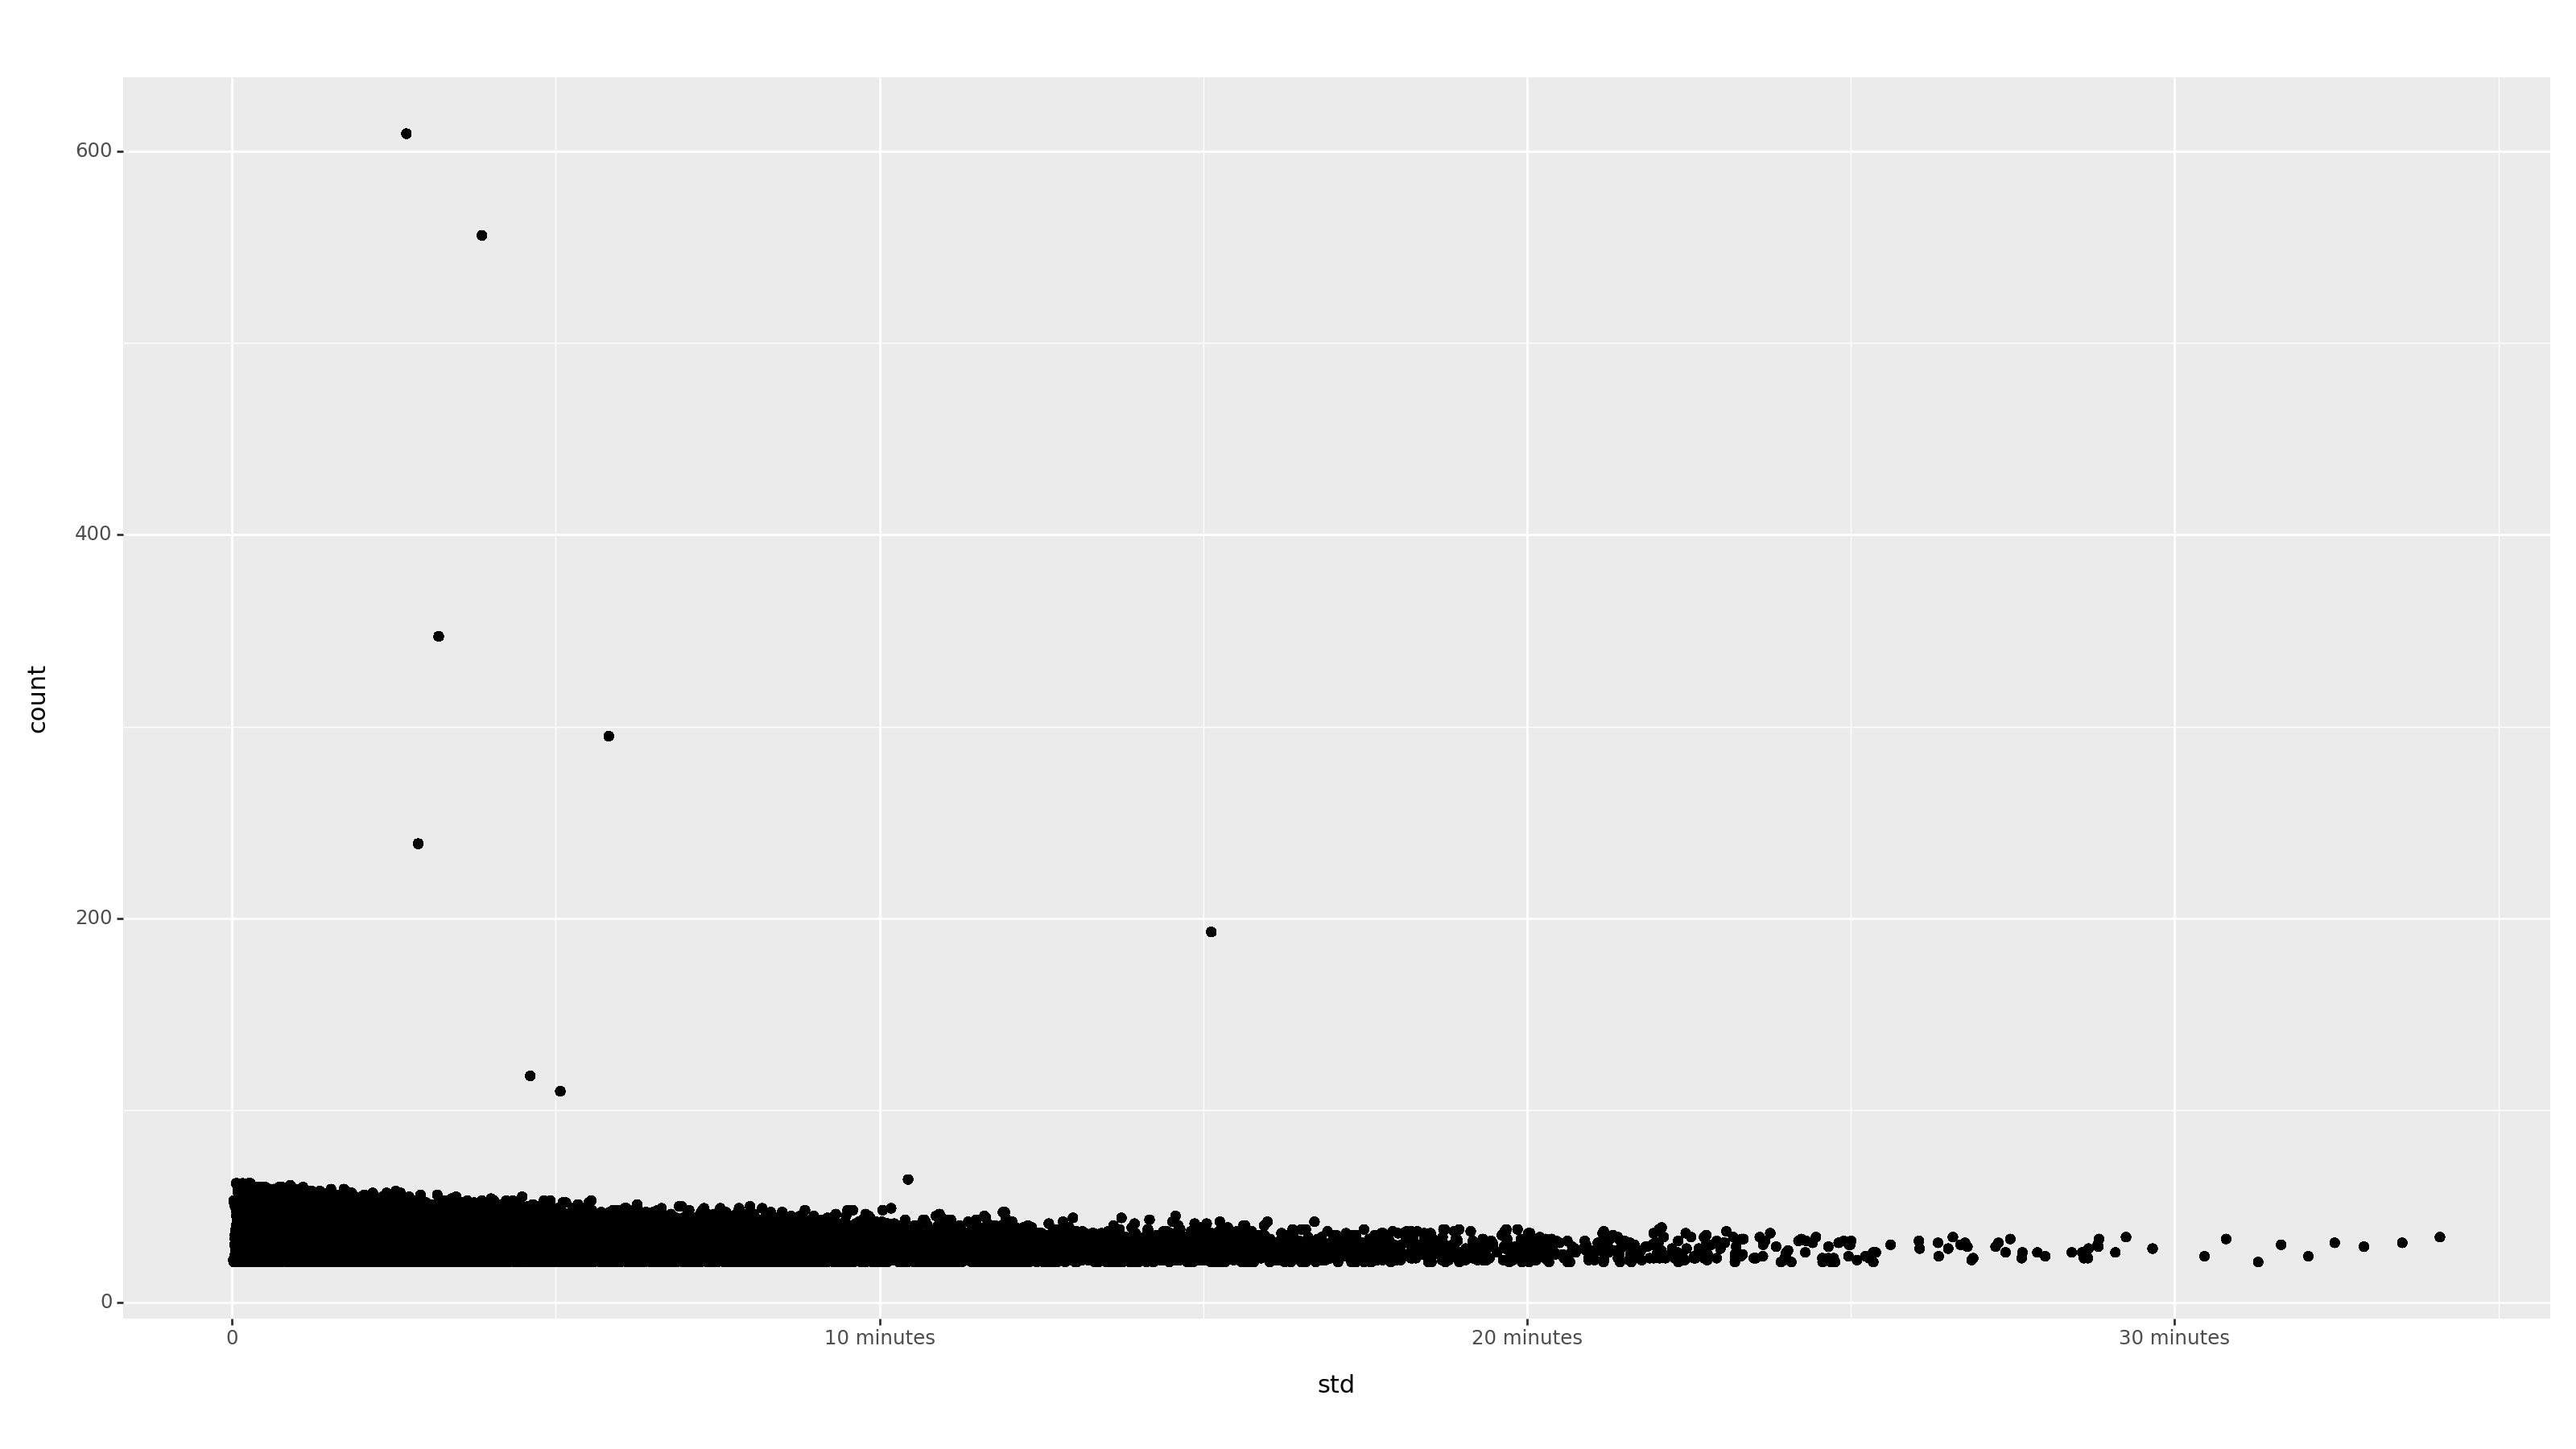

<Figure Size: (1600 x 900)>

In [8]:
(ggplot(data_join2.collect(streaming=True)) +
    geom_point(aes(x = 'std', y = 'count')) +
    theme(
        figure_size = (16,9)
    )
)


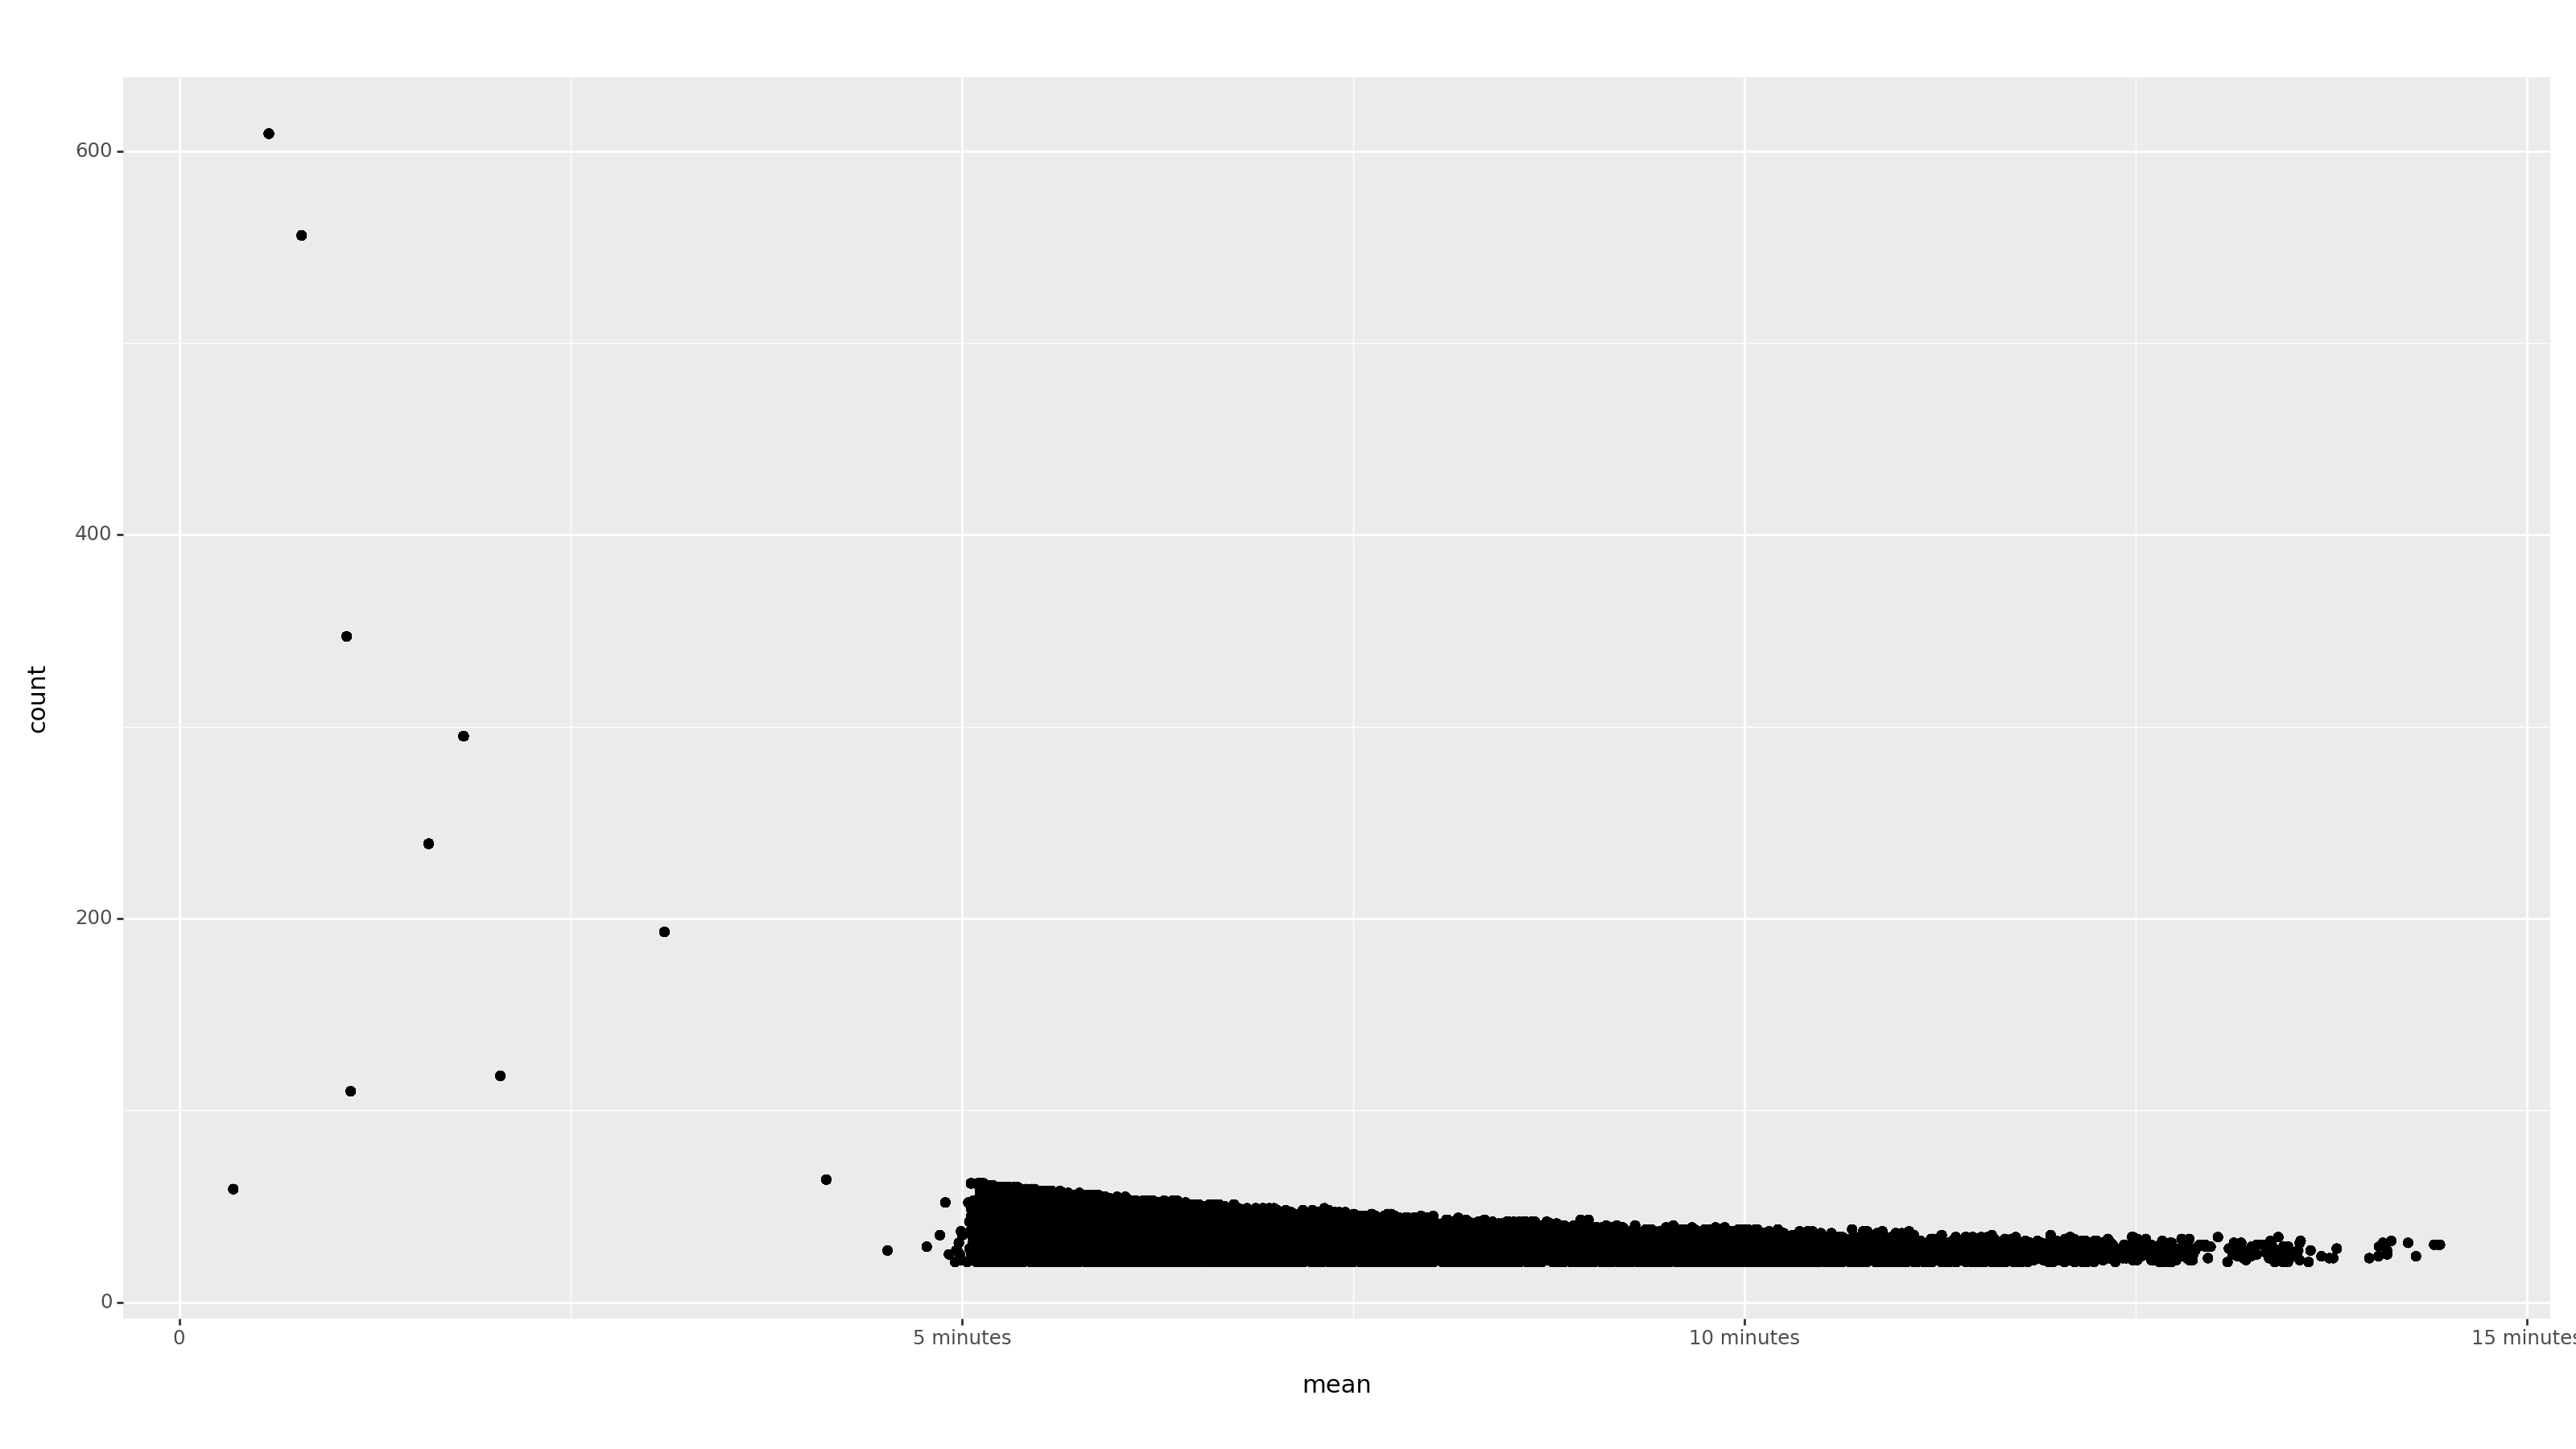

<Figure Size: (1600 x 900)>

In [9]:
(ggplot(data_join2.collect(streaming=True)) +
    geom_point(aes(x = 'mean', y = 'count')) +
    theme(
        figure_size = (16,9)
    )
)


In [ ]:
data1.plot.scatter(x = 'mean', y = 'count')